In [1]:
pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.8 MB/s eta 0:00:00


In [2]:
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord as SkyCoord
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def flux_density_cut(data,column_index,min,max):
    Index = 0
    Index_list = []
    for row in np.array(data):
        S = row[column_index]
        if S<min or S>max:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    data_array = np.array(data)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)
    return new_data

# Elimando fonte que estejam com B em [-b,b]
def galactic_cut(data,RA_column_index,Dec_column_index,Lim_inf,Lim_sup):

    data_array = np.array(data)

    ra_column_array = data_array[:,RA_column_index]
    dec_column_array = data_array[:,Dec_column_index]

    c = SkyCoord(ra_column_array,dec_column_array, frame='icrs', unit='deg')

    b_array = np.array(c.galactic.b)

    Index = 0
    Index_list = []
    for b in b_array:
        if b > Lim_inf  and b < Lim_sup:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)

    return new_data

In [4]:
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

In [5]:
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-20,20)

In [6]:
data = nvss_flux_20_1000_cut_galac

In [7]:
# RA
ra = np.array(data['RA'])
ra

array([  0.87467, 348.092  , 355.498  , ..., 310.6229 , 319.6826 ,
         6.08338])

In [8]:
# DEC
dec = np.array(data['DEC'])
dec

array([-40.15147, -40.14994, -40.14894, ..., -40.15431, -40.1535 ,
       -40.15208])

In [9]:
# RA to phi (in radians)
phi = np.radians(ra)
phi

array([0.01526587, 6.0753515 , 6.20461058, ..., 5.42139234, 5.57951393,
       0.10617501])

In [10]:
# DEC to theta (in radians)
theta = np.radians(90.0 - dec)
theta

array([2.27157168, 2.27154497, 2.27152752, ..., 2.27162125, 2.27160711,
       2.27158232])

In [11]:
nside = 64
npix = hp.nside2npix(nside)
npix

49152

In [12]:
pix_indices = hp.ang2pix(nside,theta,phi)
pix_indices

array([40320, 40567, 40572, ..., 40540, 40547, 40324])

In [13]:
# Contar o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)
density_map = density_map.astype(np.float64)
density_map

array([9., 5., 5., ..., 0., 0., 0.])

In [14]:
# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN  # Definindo pixels vazios como 'invisíveis'

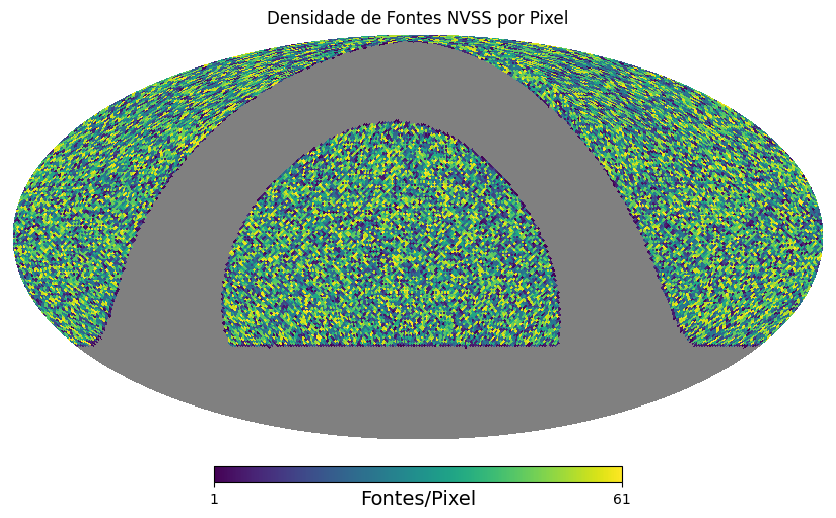

In [15]:
hp.mollview(masked_map,
            title="Densidade de Fontes NVSS por Pixel",
            unit="Fontes/Pixel",
            norm='hist')
plt.show()

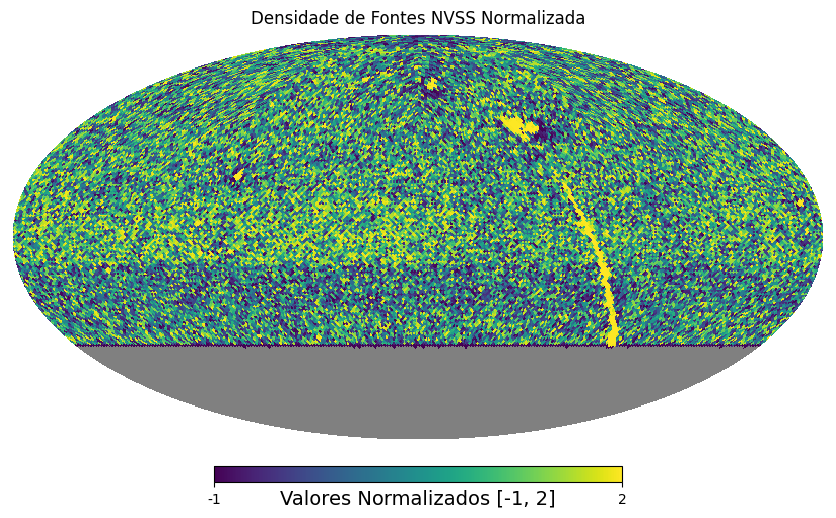

In [16]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Convertendo RA e DEC para numpy arrays
ra = np.array(nvss['RA'])  # RA
dec = np.array(nvss['DEC'])  # DEC

# Convertendo RA e DEC para ângulos theta e phi em radianos
phi = np.radians(ra)  # RA para phi (em radianos)
theta = np.radians(90.0 - dec)  # DEC para theta (em radianos)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = np.nan  # Usando np.nan para garantir que pixels mascarados não sejam normalizados

# Normalizando os valores no intervalo [-1, 2]
min_val = np.nanmin(masked_map)  # Encontrando o valor mínimo, ignorando np.nan
max_val = np.nanmax(masked_map)  # Encontrando o valor máximo, ignorando np.nan

normalized_map = 3 * (masked_map - min_val) / (max_val - min_val) - 1

# Substituindo os np.nan por hp.UNSEEN após a normalização
normalized_map[np.isnan(normalized_map)] = hp.UNSEEN

# Visualizando o mapa de densidade
hp.mollview(normalized_map, title="Densidade de Fontes NVSS Normalizada", unit="Valores Normalizados [-1, 2]",
            norm='hist')
plt.show()

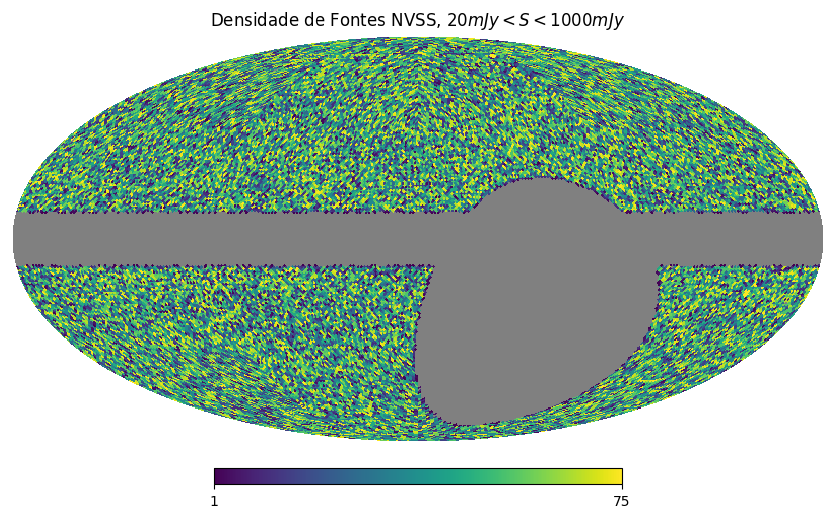

In [17]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV
name = r'Densidade de Fontes NVSS, $20mJy <S<1000mJy$'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-10,10)

data = nvss_flux_20_1000_cut_galac

# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN

# Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()


In [18]:
amp, vec = hp.fit_dipole(masked_map)

# Exibir os resultados do ajuste do dipolo
print("Amplitude do Dipolo:", amp)
print("Direção do Dipolo (vetor):", vec)

Amplitude do Dipolo: 7.8617053144853335
Direção do Dipolo (vetor): [-0.08399668 -0.08730251  0.10422571]


# TGSS

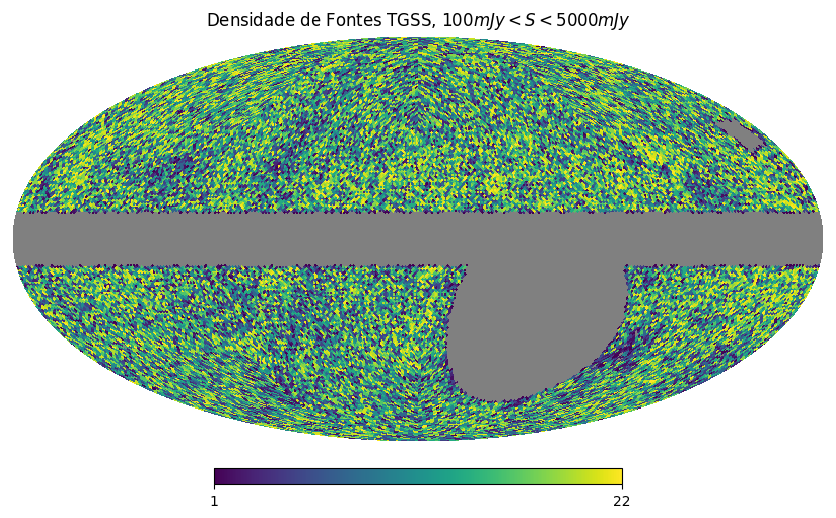

In [19]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV

name = r'Densidade de Fontes TGSS, $100mJy <S<5000mJy$'
tgss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /TGSS_coord_flux_Colunas_2_a_7_CSV')

tgss_flux_100_5000 = flux_density_cut(tgss,4,100,5000)
tgss_flux_100_5000_cut_galac = galactic_cut(tgss_flux_100_5000,0,2,-10,10)

data = tgss_flux_100_5000_cut_galac

# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

# Estimador


In [23]:
# Estimador

@numba.jit
def calculo_delta(coord_ca_cartesian_array, coord_cartesian_array,f_sky):
    f_sky_i = f_sky
    numero_fontes_total = len(coord_ca_cartesian_array)
    sigma_total = numero_fontes_total/(4*np.pi*f_sky)

    delta_list = []
    delta_coord = []

    for x,y,z in coord_cartesian_array:
        up_hemisphere = 0
        down_hemisphere = 0
        for a,b,c in coord_ca_cartesian_array:
            # Se A*B > 0 --->>  Então B é do hemisferio up
            if a*x+b*y+c*z > 0:
                up_hemisphere = up_hemisphere + 1
            # Se A*B < 0 --->>  Então B é do hemisferio down
            if a*x+b*y+c*z < 0:
                down_hemisphere = down_hemisphere + 1

        sigma_up = up_hemisphere/(2*np.pi*f_sky_i)
        sigma_down = down_hemisphere/(2*np.pi*f_sky_i)
        delta = (sigma_up - sigma_down)/sigma_total

        delta_list.append(delta) # adicionar as coordenadas na lista p/ delta
        delta_coord.append([x,y,z]) # adicionar as coordenadas delta

    return delta_list, delta_coord

def estimator(dataframe,coord_cartesian_array,f_sky,ra_index,dec_index):

    # Transformando DataFrame em Numpy Array
    data_array = np.array(dataframe)
    # Pegando as ordenadas Ascenção Reta e Declinação do Array acima
    ra_ca, dec_ca= data_array[:,ra_index] , data_array[:,dec_index]
    # Obtendo coordenadas no Astropy
    c_ca = c_ca = SkyCoord(ra_ca,dec_ca,frame='icrs', unit='deg')
    # Obtendo as coordenadas na forma cartesianas
    a,b,c = c_ca.cartesian.x, c_ca.cartesian.y, c_ca.cartesian.z
    # Transformando as coordenadas cartesianas em arrays separadamente
    a_array,b_array,c_array = np.array(a),np.array(b),np.array(c)
    # Juntando cada array acima na forma colunas em novo array
    coord_ca_cartesian_array = np.stack([a_array,b_array,c_array],axis=1)

    delta_list,delta_coord = calculo_delta(coord_ca_cartesian_array, coord_cartesian_array,f_sky)

    deltas_array = np.array(delta_list).reshape(-1,1)
    deltas_coord = np.array(delta_coord)

    index_min = np.where(deltas_array==deltas_array.min())[0][0]
    index_max = np.where(deltas_array==deltas_array.max())[0][0]

    x_min,y_min,z_min = deltas_coord[index_min][0], deltas_coord[index_min][1], deltas_coord[index_min][2]
    x_max,y_max,z_max = deltas_coord[index_max][0], deltas_coord[index_max][1], deltas_coord[index_max][2]
    # mudando coordenadas para galácticas
    c_min = SkyCoord(x_min, y_min, z_min, representation_type='cartesian')
    c_max = SkyCoord(x_max, y_max, z_max, representation_type='cartesian')

    amp = (deltas_array.min(),deltas_array.max())
    dir = (c_min.galactic.l.value, c_min.galactic.b.value),(c_max.galactic.l.value, c_max.galactic.b.value)

    return amp, dir

# Testando estimador para NVSS

In [26]:
# Importando o catálogo NVSS em CSV
name = r'Densidade de Fontes NVSS, $20mJy <S<1000mJy$'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Eliminando fontes com S entre 20 mJy e 1000 mJy
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-10,10)

data = nvss_flux_20_1000_cut_galac

In [31]:
# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

In [32]:
# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)
npix

49152

In [33]:
# Criando um array cujos os elementos são os indices dos pixels
array_ipix = np.arange(npix)
array_ipix

array([    0,     1,     2, ..., 49149, 49150, 49151])

In [34]:
# Obtendo os angulos em coordenadas esféricas padrão em radianos
theta, phi = hp.pix2ang(nside, np.arange(npix))
theta, phi

# Convertendo theta e phi p/ ra e dec
ra = np.degrees(phi)
dec = 90 - np.degrees(theta)

c = SkyCoord(ra,dec, frame='icrs',unit='deg')

hp_coords_equa = c.icrs
hp_coords_galac = c.galactic

In [35]:
l = hp_coords_galac.l.degree
b = hp_coords_galac.b.degree

# Pilha com indices e coordendas galacticas
np.stack((array_ipix, l, b), axis=1)

array([[ 0.00000000e+00,  1.23366479e+02,  2.65086383e+01],
       [ 1.00000000e+00,  1.23629810e+02,  2.75154006e+01],
       [ 2.00000000e+00,  1.22492534e+02,  2.77465142e+01],
       ...,
       [ 4.91490000e+04,  3.02238877e+02, -2.67376784e+01],
       [ 4.91500000e+04,  3.03366479e+02, -2.65086383e+01],
       [ 4.91510000e+04,  3.03629810e+02, -2.75154006e+01]])

In [ ]:
coord_cartesian_array